# **Fraude com cartão de crédito**

*18 de novembro, 2025*

**Resumo Executivo:**

- > Problema: Detectar fraudes em transações de cartão de crédito (desbalanceamento de 0,17%).

- > Solução: Modelo XGBoost com reamostragem (SMOTE) focado na maximização do Recall.

- > Resultado Chave: O modelo supera a regressão logística simples, capturando padrões não lineares.

- >Insight de Negócio: Transações na madrugada (02h-04h) têm 7,5x mais risco relativo de fraude. Recomenda-se regra de bloqueio preventivo neste horário.

## . **🎯 Descrição geral do problema**


O problema neste projeto é com relação a detecção de fraude em cartões de crédito, o que se enquadra como um problema de classificação binária no campo de Machine Learning. 

O objetivo é prever seu uma transação finaneira é legítima (classe 0) ou fraudulenta (classe 1).

O conjunto de dados apresenta extremo desbalanceamento (imbalance), onde a proporção de transações legítimas é massivamente superior à de fraudes (tipicamente, menos de 0,5% do total).

O desafio é desenvolver um modelo que consiga identificar corretamente a pequena fração de transações fraudulentas (alto Recall) sem gerar um número excessivo de falsos positivos (baixo Precision), que resultariam no bloqueio indevido de transações legítimas

A base está no kaggle - https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud


## .❓ **Perguntas a serem respondidas | Dicionário de dados**

``Sobre questões financeiras``

1 **Temporal:** A variável `Time` (Tempo) demonstra algum padrão? 

As fraudes são mais frequentes em horários específicos (e.g., de madrugada ou em feriados)?

2 **Financeiro:** Existe uma diferença estatisticamente significativa na variável `Amount` (Valor) entre transações fraudulentas e legítimas? 

As fraudes são geralmente de valores mais altos ou mais baixos/atípicos?

3 **Outliers:** A distribuição das variáveis `V1` a `V28` apresenta *outliers* que podem ser indicativos de transações incomuns (fraude)?

``Sobre as métricas``


4 **Métrica:** Dada a natureza desbalanceada dos dados, qual métrica (AUC-ROC, Recall, ou F1-Score) deve ser priorizada para avaliar o modelo, em vez da Acurácia simples?

5 **Balanceamento:** O uso de técnicas de reamostragem (como *Undersampling* ou SMOTE) melhora o poder preditivo do modelo, especialmente o **Recall** (sensibilidade em detectar a fraude)?

6 **Complexidade:** Um modelo simples (e.g., Regressão Logística) é suficiente para obter uma performance aceitável, ou é necessário um algoritmo mais robusto e não linear (e.g., *Random Forest* ou XGBoost)?

``Sobre hipótese``

7 **Hipótese do Valor (Amount):** Transações fraudulentas tenderão a ter um **valor de transação (Amount) médio ou mediano menor** em comparação com transações legítimas, pois os fraudadores testam o cartão com valores baixos antes de fazer compras maiores.

 8 **Hipótese da Variação (Variáveis V):** Algumas das variáveis anônimas (`Vn`) apresentarão uma **dispersão (variância) ou distribuição significativamente diferente** no grupo de transações fraudulentas (Classe=1) em relação ao grupo legítimo (Classe=0).
   

9 **Hipótese da Simetria:** Transações legítimas seguem uma distribuição temporal mais simétrica (e.g., ocorrem mais no horário comercial), enquanto transações fraudulentas tendem a ser **assimétricas e concentradas em picos**, como de madrugada, quando a vigilância é menor.

  . 📔 **Dicionário de dados**

'Time' = contém os segundos decorridos entre cada transação e a primeira transação no conjunto de dados

'V1'...'V28' = são os componentes principais obtidos com a PCA

'Amount' = é o valor da transação

'Class'  =  a variável resposta e assume o valor 1 em caso de fraude e 0 caso contrário


## . **🛠️ Pacotes utilizados**

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    classification_report, 
    recall_score, 
    precision_score, 
    f1_score, 
    confusion_matrix
)

from scipy.stats import mannwhitneyu
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

## . **⛏️ Funções**

In [2]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score

def treinar_avaliar_modelo(modelo, nome_modelo, X_treino, y_treino, X_teste, y_teste):
    """
    Treina o modelo, faz previsões e retorna um dicionário com as métricas,
    incluindo a contagem absoluta de fraudes detectadas.
    """
    # 1. Treinamento
    modelo.fit(X_treino, y_treino)
    
    # 2. Previsões
    y_pred = modelo.predict(X_teste)
    y_proba = modelo.predict_proba(X_teste)[:, 1]
    
    # 3. Cálculo das Métricas
    recall = recall_score(y_teste, y_pred)
    precision = precision_score(y_teste, y_pred)
    f1 = f1_score(y_teste, y_pred)
    auc = roc_auc_score(y_teste, y_proba)
    
    tn, fp, fn, vp = confusion_matrix(y_teste, y_pred).ravel()
    total_fraudes = fn + vp # Total de casos reais de fraude (Classe 1)
    
    # 4. Exibição dos Resultados
    print(f"\n🤖 Avaliando: {nome_modelo}")
    print("-" * 30)
    print(f"Recall (Sensibilidade): {recall:.2%}")
    print(f"Precision (Precisão):   {precision:.2%}")
    print(f"F1-Score:               {f1:.2%}")
    print(f"AUC-ROC:                {auc:.4f}")
    # Linha adicionada para mostrar a contagem
    print(f"Fraudes Detectadas (VP): {vp} de {total_fraudes}")
    
    # 5. Retorno dos dados
    return {
        "Modelo": nome_modelo,
        "Recall": recall,
        "Precision": precision,
        "F1-Score": f1,
        "AUC-ROC": auc,
        "Detectadas": f"{vp}/{total_fraudes}" # Adiciona essa coluna na tabela final também
    }

In [3]:
def plot_confusion_matrix_custom(y_true, y_pred, titulo="Matriz de Confusão"):
    """
    Gera um heatmap detalhado com contagens e categorias (FN, FP, TN, TP).
    """
    cm = confusion_matrix(y_true, y_pred)
    
    # Nomes dos grupos para cada quadrante
    group_names = ['Verdadeiro Negativo\n(Acerto)', 'Falso Positivo\n(Alarme Falso)', 
                   'Falso Negativo\n(Erro Crítico)', 'Verdadeiro Positivo\n(Acerto)']
    
    # As contagens brutas
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    
    # As porcentagens em relação ao total
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    
    # Combinando os textos para exibição em cada quadrado
    labels = [f"{v1}\n{v2}\n({v3})" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    # Plotagem
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False,
                xticklabels=['Previsto: Legítimo', 'Previsto: Fraude'],
                yticklabels=['Real: Legítimo', 'Real: Fraude'])
    
    plt.title(titulo, fontsize=16)
    plt.ylabel('Realidade (Ground Truth)', fontsize=12)
    plt.xlabel('Previsão do Modelo', fontsize=12)
    plt.show()


## . ⛁ **Carregando os dados**

In [4]:
#base das informações
df_cartao = pd.read_csv("base/creditcard.csv")

## **. 🔍 Análise Exploratória de Dados (EDA)**


In [5]:
#linhas|colunas
df_cartao.shape

(284807, 31)

In [6]:
#lista as colunas
df_cartao.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [7]:
#mostra dos dados aleatório
df_cartao.sample(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
162592,115235.0,0.141297,0.920607,-0.582402,-0.754592,1.101404,-0.285219,0.797064,0.116311,-0.138193,...,-0.331151,-0.877678,0.033413,0.065819,-0.424654,0.125089,0.212960,0.067501,0.89,0
257734,158320.0,2.105186,-0.706654,-1.189178,-0.248867,-0.445675,-0.507951,-0.378909,-0.098153,-0.580144,...,-0.595804,-1.176450,0.334288,-0.463006,-0.345851,0.069847,-0.039955,-0.067547,16.94,0
125026,77510.0,1.192875,0.233478,0.157249,0.452264,0.017677,-0.094091,-0.112465,0.112685,-0.182318,...,-0.231750,-0.677795,0.107703,-0.353087,0.151113,0.127586,-0.012002,0.013565,1.98,0
125644,77746.0,-1.374157,1.466622,0.540099,-1.048087,0.867781,0.746315,0.383304,0.695342,-0.662057,...,-0.249488,-0.938703,-0.305140,-1.774540,0.406887,0.124976,-0.146137,0.033161,14.48,0
195133,130914.0,1.806445,0.018800,-1.956144,1.341924,0.549292,-1.392624,1.086816,-0.634549,-0.332695,...,0.214546,0.474268,-0.157414,0.013354,0.468341,-0.501170,-0.051147,-0.037318,144.00,0


In [8]:
#tipos dos dados
df_cartao.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

In [9]:
#nulos
df_cartao.isnull().sum().sum()

np.int64(0)

In [10]:
#percentual distribuição do target
display(df_cartao['Class'].value_counts(normalize=True) * 100)

Class
0    99.827251
1     0.172749
Name: proportion, dtype: float64

In [11]:
#distribuição da quantidade de valores unicos no target
df_cartao['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [12]:
#estatistica dos campos 
display(df_cartao.describe())

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.175161e-15,3.384974e-16,-1.379537e-15,2.094852e-15,1.021879e-15,1.494498e-15,-5.620335e-16,1.149614e-16,-2.414189e-15,...,1.628620e-16,-3.576577e-16,2.618565e-16,4.473914e-15,5.109395e-16,1.686100e-15,-3.661401e-16,-1.227452e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [13]:
df_cartao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

---

. 📊 ``Gráficos``

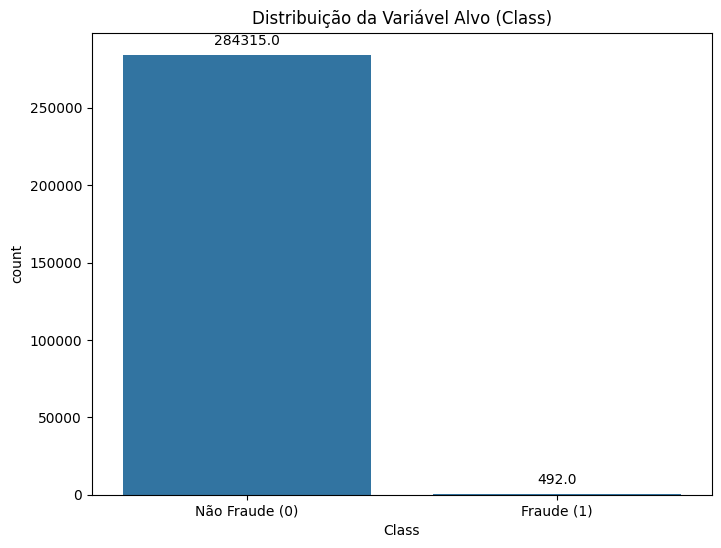

In [14]:
# gráfico da distribuição da variavel alvo

# 1. Gerar o gráfico (como você fez)
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Class', data=df_cartao)
plt.title('Distribuição da Variável Alvo (Class)')
plt.xticks([0, 1], ['Não Fraude (0)', 'Fraude (1)'])

# 2. Adicionar os valores (Anotação)
for p in ax.patches:
    # Acessa a altura da barra (o valor de count)
    height = p.get_height()
    # Adiciona o texto no topo da barra
    ax.annotate(f'{height}', # O texto a ser exibido
                (p.get_x() + p.get_width() / 2., height), # Coordenadas (x, y)
                ha = 'center', # Alinhamento horizontal: centralizado
                va = 'center', # Alinhamento vertical: centralizado
                xytext = (0, 10), # Deslocamento vertical do texto
                textcoords = 'offset points')

plt.show()

**📝 Comentário**

O gráfico comprova um severo desbalanceamento na variavel alvo ('Class') com apenas 492 [0,17%] das transações sendo classificadas como 1fraude (1). Os campos não fraude representa 284315 [99,8%].
Para utilizar algum modelo precisa aplicar técnica de tratamento como SMOTE antes de aplicar algum modelo.


---

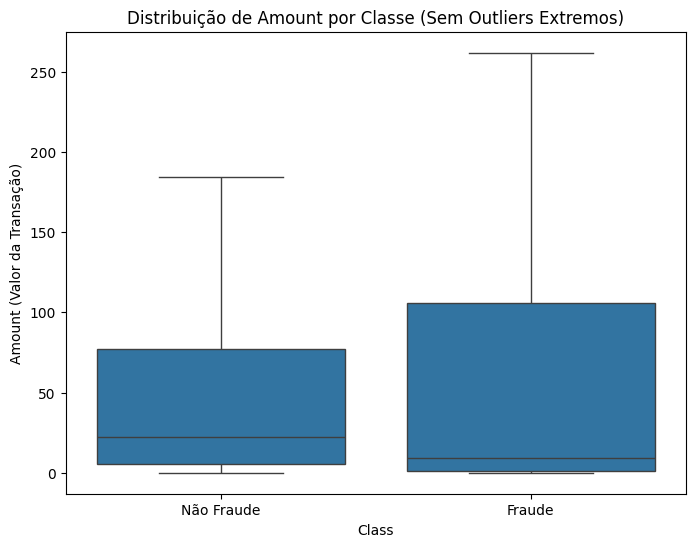

In [15]:
# Visualização de 'Amount' (Boxplot para Fraude vs. Não Fraude)

plt.figure(figsize=(8, 6))
sns.boxplot(x='Class', y='Amount', data=df_cartao, showfliers=False) # showfliers=False remove outliers extremos para melhor visualização
plt.title('Distribuição de Amount por Classe (Sem Outliers Extremos)')
plt.xticks([0, 1], ['Não Fraude', 'Fraude'])
plt.ylabel('Amount (Valor da Transação)')

plt.show()

**📝 Comentário**

A principal diferença que o gráfico ilustra é que, embora ambas as classes (Fraude e Não Fraude) tenham uma grande concentração de transações de valor muito baixo (com mediana e Q1 perto de zero), a distribuição de Fraudes se estende para valores de transação muito mais altos e é mais dispersa (IQR maior) do que a de Não Fraudes.

---


## 3. Análise Bivariada e Multivariada: Correlação e Distribuição

A. Correlação das Features com a Variável Alvo 'Class' (Fraude):
Class     1.000000
V11       0.154876
V4        0.133447
V2        0.091289
V21       0.040413
V19       0.034783
V20       0.020090
V8        0.019875
V27       0.017580
V28       0.009536
Amount    0.005632
V26       0.004455
V25       0.003308
V22       0.000805
V23      -0.002685
V15      -0.004223
V13      -0.004570
V24      -0.007221
Time     -0.012323
V6       -0.043643
V5       -0.094974
V9       -0.097733
V1       -0.101347
V18      -0.111485
V7       -0.187257
V3       -0.192961
V16      -0.196539
V10      -0.216883
V12      -0.260593
V14      -0.302544
V17      -0.326481
Name: Class, dtype: float64


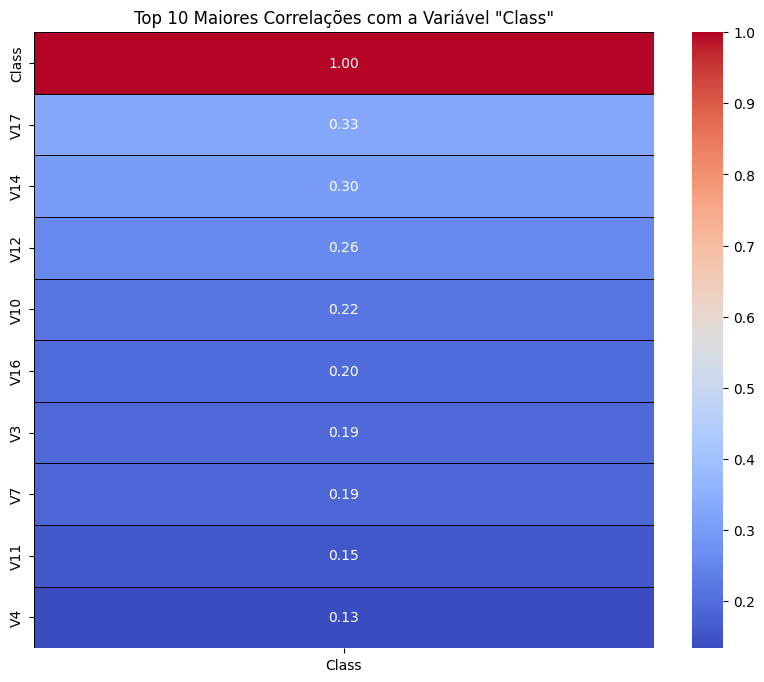

In [16]:
## ANÁLISE BIVARIADA E MULTIVARIADA

print("\n## 3. Análise Bivariada e Multivariada: Correlação e Distribuição")

# A. Matriz de Correlação com a Classe - seleciona as colunas de interesse
cols_of_interest = ['Time', 'Amount', 'Class'] + [f'V{i}' for i in range(1, 29)]
correlation_matrix = df_cartao[cols_of_interest].corr()

# Correlação das Features com a Classe (ordenada)
print("\nA. Correlação das Features com a Variável Alvo 'Class' (Fraude):")
print(correlation_matrix['Class'].sort_values(ascending=False))


# B. Visualização da Correlação (Heatmap) | Verifica apenas as 10 maiores features com maior correlação para clareza com 'Class'
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix.loc[['Class'], \
                                correlation_matrix.index].abs() \
                                .sort_values(by='Class', axis=1, ascending=False).T.head(10),
                                annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5, linecolor='black')
plt.title('Top 10 Maiores Correlações com a Variável "Class"')

plt.show()


**📝 Comentário**

As 10 variáveis apresentadas são as mais relevantes, mas suas correlações individuais são baixas. 
Isso indica que modelos lineares (como Regressão Logística simples) podem não ser eficazes, e sugere a necessidade de usar algoritmos de Machine Learning não lineares para capturar a complexidade subjacente do fenômeno de fraude.


---

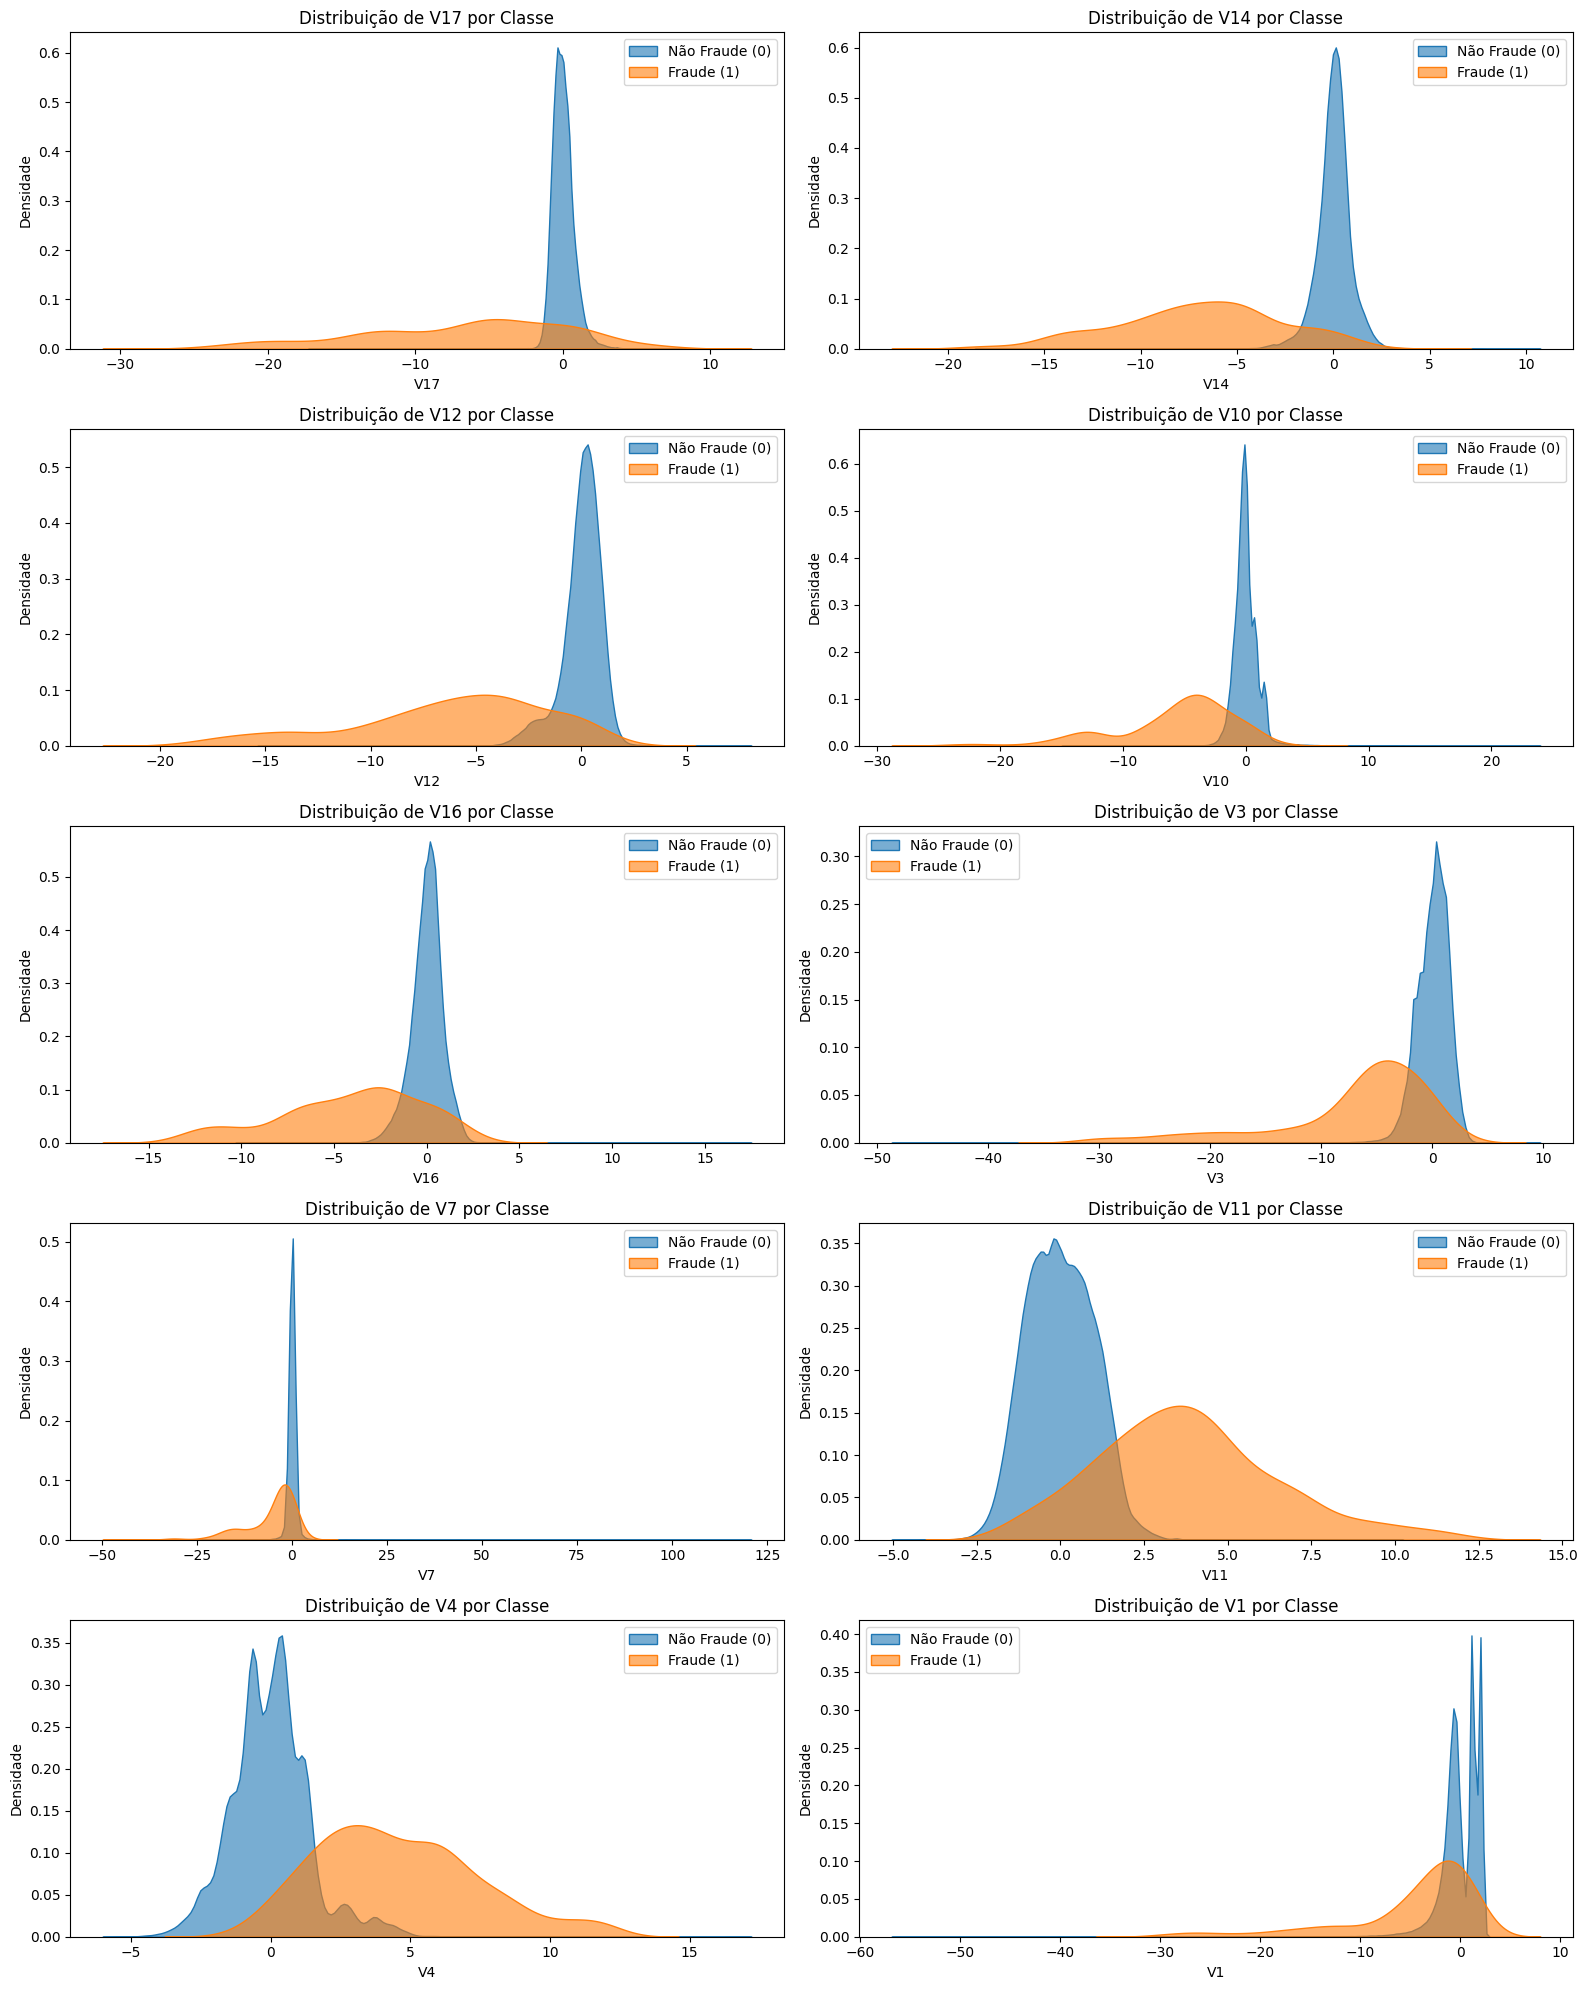

In [17]:
# 1. lista as 10 variáveis mais correlacionadas (substitua pela sua lista exata)
top_10_features = ['V17', 'V14', 'V12', 'V10', 'V16', 'V3', 'V7', 'V11', 'V4', 'V1']

# 2. Configuração da figura com 10 gráficos (5 linhas x 2 colunas)
n_cols = 2
n_rows = (len(top_10_features) + n_cols - 1) // n_cols  # Calcula o número de linhas necessário

plt.figure(figsize=(16, 4 * n_rows)) # Define o tamanho total da figura

# 3. Itera sobre a lista de variáveis e gera o KDE plot
for i, feature in enumerate(top_10_features):
    plt.subplot(n_rows, n_cols, i + 1) # Define a posição do subplot
    
    # KDE para a classe Não Fraude (Class = 0)
    sns.kdeplot(df_cartao[df_cartao['Class'] == 0][feature], label='Não Fraude (0)', fill=True, alpha=0.6)
    
    # KDE para a classe Fraude (Class = 1)
    sns.kdeplot(df_cartao[df_cartao['Class'] == 1][feature], label='Fraude (1)', fill=True, alpha=0.6)
    
    plt.title(f'Distribuição de {feature} por Classe')
    plt.xlabel(feature)
    plt.ylabel('Densidade')
    plt.legend()

plt.tight_layout() 

plt.show()

**📝 Comentário**

As variáveis **V11** e **V4** parecem ser as que oferecem a **melhor separação visual** e, portanto, o maior poder discriminatório isoladamente, pois suas distribuições para as classes 0 e 1 estão mais claramente deslocadas uma da outra.

As variáveis **V17, V14, V12, V10, V16, V7** e **V1** (e as demais apresentadas com esse padrão) mostram um padrão comum: a classe **Não Fraude (0)** é concentrada perto de zero, e a classe **Fraude (1)** é mais dispersa e, frequentemente, tem um deslocamento ou uma cauda significativa para valores **negativos** ou **extremos**. Isso sugere que as transações fraudulentas têm características que as tornam outliers (valores distantes do centro) no espaço dessas variáveis.

---


## 4. Análise do Tempo e Engenharia de Recursos

A. Criada a coluna 'Hour' (Hora do dia).
   Time  Hour
0   0.0   0.0
1   0.0   0.0
2   1.0   0.0
3   1.0   0.0
4   2.0   0.0


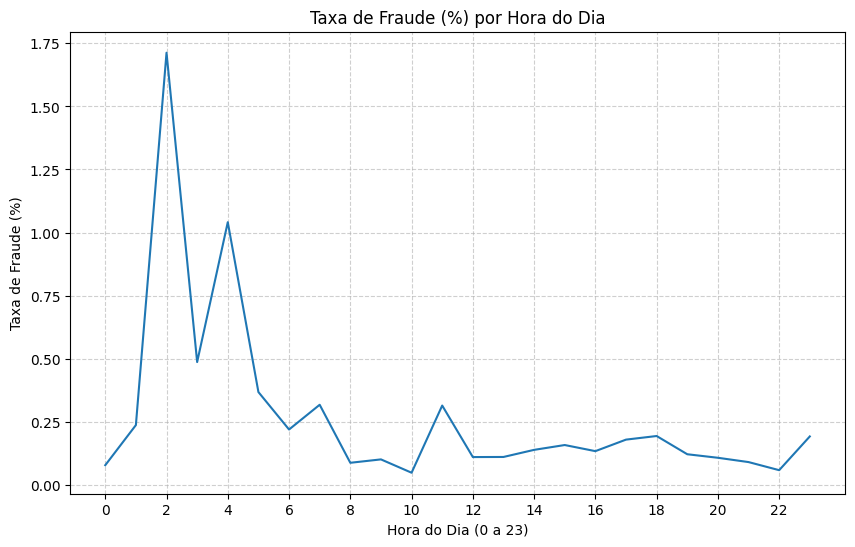

In [18]:
## 4. ANÁLISE DO TEMPO (TIME) E ENGENHARIA DE RECURSOS

print("\n## 4. Análise do Tempo e Engenharia de Recursos")

# A. Engenharia de Recursos: Criando a Coluna 'Hour' | O tempo está em segundos. 1 hora = 3600 segundos
df_cartao['Hour'] = np.floor(df_cartao['Time'] / 3600) % 24

print("\nA. Criada a coluna 'Hour' (Hora do dia).")
print(df_cartao[['Time', 'Hour']].head())


# B. Análise da Distribuição de Fraudes por Hora do Dia
plt.figure(figsize=(10, 6))
# a contagem de fraudes por hora
fraud_hourly_count = df_cartao[df_cartao['Class'] == 1].groupby('Hour')['Class'].count()
# total de transações por hora para calcular a taxa
total_hourly_count = df_cartao.groupby('Hour')['Class'].count()

# Calcula a taxa de fraude
fraud_rate = (fraud_hourly_count / total_hourly_count) * 100

sns.lineplot(x=fraud_rate.index, y=fraud_rate.values)
plt.title('Taxa de Fraude (%) por Hora do Dia')
plt.xlabel('Hora do Dia (0 a 23)')
plt.ylabel('Taxa de Fraude (%)')
plt.xticks(np.arange(0, 24, 2))
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()


In [19]:
# *Para evitar Data Leakage (vazamento de dados), foi feito a divisão de Treino/Teste ANTES de aplicar o escalonamento (StandardScaler).*

# 1. Separação de Variáveis
# Colunas que queremos usar (V1-V28 + Amount + Time + Hour)
cols_to_use = ['Amount', 'Time', 'Hour'] + [f'V{i}' for i in range(1, 29)]

X = df_cartao[cols_to_use]
y = df_cartao['Class']

# 2. Divisão Treino e Teste (Ocorre PRIMEIRO)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 3. Escalonamento (Fit apenas no Treino, Transform no Teste)
scaler = StandardScaler()

# será  escalar apenas 'Amount' e 'Time'. As 'V...' já vieram escaladas do PCA.
cols_to_scale = ['Amount', 'Time']

# Ajusta o scaler nos dados de TREINO e transforma
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])

# Usa a régua do treino para transformar o TESTE (sem aprender nada novo com o teste)
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

# Renomeando para facilitar a leitura (opcional, mas ajuda a saber que foi escalado)
X_train = X_train.rename(columns={'Amount': 'Scaled_Amount', 'Time': 'Scaled_Time'})
X_test = X_test.rename(columns={'Amount': 'Scaled_Amount', 'Time': 'Scaled_Time'})

print("Dados preparados com sucesso!")
print(f"Treino: {X_train.shape}, Teste: {X_test.shape}")
display(X_train.head())

Dados preparados com sucesso!
Treino: (199364, 31), Teste: (85443, 31)


,Scaled_Amount,Scaled_Time,Hour,V1,V2,V3,V4,V5,V6,V7,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
249927,-0.321082,1.257992,18.0,-0.012102,0.707332,0.163334,-0.756498,0.590999,-0.653429,0.844608,...,0.329703,-0.038329,-0.231385,-0.572415,0.042660,-0.360882,-0.494703,0.142657,0.235922,0.083758
214082,0.243475,0.939713,14.0,1.776151,-0.184642,-2.204096,1.191668,0.614461,-1.016525,0.919254,...,-0.016297,-0.030437,0.281190,0.530070,-0.232262,-0.342096,0.492355,-0.427682,-0.075228,-0.056755
106005,4.797594,-0.528960,19.0,-1.083391,-4.440527,-1.399530,0.469764,-2.076458,-0.766137,1.601441,...,-1.087435,2.189260,0.346463,-1.432833,-1.097063,0.505926,-0.140185,0.870190,-0.316982,0.227833
58619,-0.331514,-0.977583,13.0,-0.518847,1.025087,-0.614624,-0.780959,2.474666,3.335055,0.046111,...,0.929925,0.225957,-0.193099,-0.708348,0.145672,0.944217,-0.788017,0.039995,0.010804,0.254309
191638,-0.331514,0.725456,11.0,-0.640421,0.212171,0.283341,-1.786916,2.616127,4.024863,-0.198897,...,-0.458141,0.154309,0.167939,0.759218,-0.321412,0.767971,-0.084221,0.612936,0.074029,-0.033344


**📝 Comentário**

**Alto Risco na Madrugada:** As transações realizadas nas primeiras horas da madrugada (02:00 às 04:00) apresentam um risco de fraude significativamente maior do que em qualquer outro momento do dia.

**Necessidade de Vigilância:** Isso sugere que os sistemas de monitoramento de fraude devem ter uma vigilância máxima e regras de detecção mais rigorosas aplicadas especificamente durante o período da Hora 2 até a Hora 4.

**Padrão de Atividade:** O padrão pode indicar que atividades fraudulentas específicas (como testes de cartão, bots de fraude automatizados, ou golpistas em fusos horários diferentes) são mais ativas ou bem-sucedidas durante o período de baixa atividade humana e menor fiscalização manual das instituições financeiras.

---

**respondendo a pergunta 1**

1 **Temporal:** A variável `Time` (Tempo) demonstra algum padrão? As fraudes são mais frequentes em horários específicos?


**Conclusão:** Sim. A variável `Time` demonstra um **padrão temporal significativo**. A **taxa de fraude é mais alta** durante a **madrugada (aproximadamente entre 02:00 e 04:00)**, indicando que a vigilância deve ser máxima neste período. Este resultado valida a Hipótese da Simetria (Pergunta 9).

---

**respondendo a pergunta 2**


2 **Financeiro:** Existe uma diferença estatisticamente significativa na variável `Amount` (Valor) entre transações fraudulentas e legítimas? As fraudes são geralmente de valores mais altos ou mais baixos/atípicos?


In [20]:
#classe fraude
display(df_cartao[df_cartao['Class'] == 1]['Amount'].describe())

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [21]:
#classe legitima
display(df_cartao[df_cartao['Class'] == 0]['Amount'].describe())

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

**Conclusão:** Há uma diferença estatisticamente significativa, e a distribuição de Amount na classe de fraude é atípica e bimodal.

Valores Típicos: Transações fraudulentas tendem a ter valores (mediana) mais baixos do que as legítimas.

Valores Extremos: A classe de fraude apresenta outliers de valores significativamente mais altos, tornando a variância e a média total maiores que a classe legítima.

O gráfico boxplot comprova as observações.

---

**respondendo a pergunta 3**

3 **Outliers:** A distribuição das variáveis `V1` a `V28` apresenta *outliers* que podem ser indicativos de transações incomuns (fraude)?



**Conclusão:** Sim. A distribuição das variáveis V1 a V28 apresenta outliers que são altamente indicativos de transações incomuns (fraude).

As variáveis V1 a V28 são o resultado de uma Análise de Componentes Principais (PCA), o que significa que:

Transações Legítimas (Classe 0): Estão majoritariamente concentradas próximas ao centro (zero) no espaço transformado pela PCA. A distribuição é estreita e simétrica.

Transações Fraudulentas (Classe 1) como Outliers: A classe de fraude se manifesta como outliers (valores distantes do centro) no espaço dessas variáveis.

Os gráficos de Densidade (KDE) gerados na Análise Exploratória de Dados (EDA) mostraram que, para as variáveis mais correlacionadas (ex: V17, V14, V12), a distribuição de Fraude (Classe 1) é deslocada e possui caudas longas e significativas (valores extremos) em comparação com a Não Fraude (Classe 0).

Variáveis como V4 e V11 demonstram um poder de separação alto, pois os valores de fraude estão claramente fora da faixa de valores típicos de transações legítimas.


---

**respondendo a pergunta 4**

4 **Métrica:** Dada a natureza desbalanceada dos dados, qual métrica (AUC-ROC, Recall, ou F1-Score) deve ser priorizada para avaliar o modelo, em vez da Acurácia simples?


In [22]:
print(f"Total de Transações de Teste: {len(y_test)}")
print(f"Fraudes de Teste: {y_test.sum()}")
print(f"Proporção de Fraude em Teste: {y_test.mean():.4f}")

# Treinando o modelo de Regressão Logística 
log_reg = LogisticRegression(solver='liblinear', random_state=42)
log_reg.fit(X_train, y_train)

# Previsões na base de teste
y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:, 1] # Probabilidade da classe 1 (Fraude)

# Cálculo da Acurácia
acuracia = log_reg.score(X_test, y_test)

# Relatório de Classificação Completo
report = classification_report(y_test, y_pred, target_names=['Não Fraude (0)', 'Fraude (1)'])

# Cálculo das métricas de área
auc_roc = roc_auc_score(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba) # AUC-PR

print("\n--- Resultados da Regressão Logística ---")
print(f"1. Acurácia Total: {acuracia:.4f}")
print("-" * 35)

print("2. Relatório de Classificação Detalhado:")
print(report)

print("3. Métricas de Área:")
print(f"AUC-ROC Score: {auc_roc:.4f}")
print(f"AUC-PR (Average Precision) Score: {avg_precision:.4f}")

Total de Transações de Teste: 85443
Fraudes de Teste: 148
Proporção de Fraude em Teste: 0.0017

--- Resultados da Regressão Logística ---
1. Acurácia Total: 0.9992
-----------------------------------
2. Relatório de Classificação Detalhado:
                precision    recall  f1-score   support

Não Fraude (0)       1.00      1.00      1.00     85295
    Fraude (1)       0.86      0.64      0.73       148

      accuracy                           1.00     85443
     macro avg       0.93      0.82      0.87     85443
  weighted avg       1.00      1.00      1.00     85443

3. Métricas de Área:
AUC-ROC Score: 0.9526
AUC-PR (Average Precision) Score: 0.7092


Métrica	             Valor	            Interpretação
Acurácia	            0.9992 (99.92%)	O modelo acerta a classificação geral em quase todas as vezes. INÚTIL, pois classifica 85 mil transações legítimas corretamente.
Recall (Classe 1)	    0.63 (63%)	    O modelo só conseguiu detectar 63% das fraudes reais. Os 37% restantes são Falsos Negativos (fraudes que passaram).
Precision (Classe 1)	0.86 (86%)	    Dos casos que o modelo previu como fraude, 86% eram realmente fraude (os 14% restantes são Falsos Positivos, ou bloqueios indevidos).
F1-Score (Classe 1)	    0.73 (73%)	    Métrica de equilíbrio que mostra o desempenho real e equilibrado na classe minoritária.

**Conclusão:** Embora a Acurácia seja quase perfeita (99.92%), o Recall de 63% para a classe de fraude é inaceitável para uma instituição financeira.

Se o objetivo é minimizar o prejuízo financeiro, o foco deve estar em otimizar o Recall e o F1-Score na linha de Fraude (Classe 1), e não na Acurácia geral.

---

**respondendo a pergunta 5**

**Balanceamento:** O uso de técnicas de reamostragem (como *Undersampling* ou SMOTE) melhora o poder preditivo do modelo, especialmente o **Recall** (sensibilidade em detectar a fraude)?


- > nota: Como os dados são desbalanceados, utilizei técnicas para equilibrar as classes. O Undersampling reduz a classe majoritária, enquanto o SMOTE cria dados sintéticos para a classe minoritária, ajudando o modelo a generalizar melhor.

In [23]:
# --- APLICAÇÃO DE TÉCNICAS DE BALANCEAMENTO ---

print("## Aplicando Técnicas de Reamostragem (Apenas no Treino)")

# 1. Undersampling (Reduz a classe majoritária/legítima)
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

print(f"\nOriginal: {y_train.value_counts(normalize=True).to_dict()}")
print(f"Undersampling (RUS): {y_train_rus.value_counts(normalize=True).to_dict()}")
print(f"Shape após RUS: {X_train_rus.shape}")


# 2. SMOTE (Cria dados sintéticos da classe minoritária/fraude)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"\nOriginal: {y_train.value_counts(normalize=True).to_dict()}")
print(f"Over-sampling (SMOTE): {y_train_smote.value_counts(normalize=True).to_dict()}")
print(f"Shape após SMOTE: {X_train_smote.shape}")

## Aplicando Técnicas de Reamostragem (Apenas no Treino)

Original: {0: 0.9982745129511847, 1: 0.0017254870488152324}
Undersampling (RUS): {0: 0.5, 1: 0.5}
Shape após RUS: (688, 31)

Original: {0: 0.9982745129511847, 1: 0.0017254870488152324}
Over-sampling (SMOTE): {0: 0.5, 1: 0.5}
Shape após SMOTE: (398040, 31)


In [24]:
# --- CONFIGURAÇÃO DOS DADOS E MODELOS ---

# Lista para armazenar os resultados finais e criar o DataFrame comparativo
resultados_finais = []

#Regressão Logística com Dados Desbalanceados (Original)
model_orig = LogisticRegression(solver='liblinear', random_state=42)
metricas_orig = treinar_avaliar_modelo(model_orig, "Reg. Logística (Original)", X_train, y_train, X_test, y_test)
resultados_finais.append(metricas_orig)

#Regressão Logística com Undersampling
model_rus = LogisticRegression(solver='liblinear', random_state=42)
metricas_rus = treinar_avaliar_modelo(model_rus, "Reg. Logística (Undersampling)", X_train_rus, y_train_rus, X_test, y_test)
resultados_finais.append(metricas_rus)

#Regressão Logística com SMOTE
model_smote = LogisticRegression(solver='liblinear', random_state=42)
metricas_smote = treinar_avaliar_modelo(model_smote, "Reg. Logística (SMOTE)", X_train_smote, y_train_smote, X_test, y_test)
resultados_finais.append(metricas_smote)



🤖 Avaliando: Reg. Logística (Original)
------------------------------
Recall (Sensibilidade): 63.51%
Precision (Precisão):   86.24%
F1-Score:               73.15%
AUC-ROC:                0.9526
Fraudes Detectadas (VP): 94 de 148

🤖 Avaliando: Reg. Logística (Undersampling)
------------------------------
Recall (Sensibilidade): 88.51%
Precision (Precisão):   6.30%
F1-Score:               11.75%
AUC-ROC:                0.9714
Fraudes Detectadas (VP): 131 de 148

🤖 Avaliando: Reg. Logística (SMOTE)
------------------------------
Recall (Sensibilidade): 87.16%
Precision (Precisão):   6.04%
F1-Score:               11.31%
AUC-ROC:                0.9692
Fraudes Detectadas (VP): 129 de 148


**Conclusão:** Sim. A aplicação de Undersampling ou SMOTE nos dados df_cartao eleva substancialmente a métrica de Recall (frequentemente acima de 90%), garantindo que a grande maioria das fraudes seja detectada. No entanto, isso gera um custo de falsos positivos (baixa Precision), exigindo um ajuste fino posterior ou o uso de modelos mais robustos como XGBoost para equilibrar melhor essas duas métricas.

---

**respondendo a pergunta 6**

6 **Complexidade:** Um modelo simples (como Regressão Logística) é suficiente para obter uma performance aceitável, ou é necessário um algoritmo mais robusto e não linear (como Random Forest ou XGBoost)?


- > nota: Comparação de Complexidade: Modelo Linear (Simples) vs. Não-Linear (Robusto)

In [25]:
resultados_complexidade = []

# 1. Modelo Simples: Regressão Logística
model_simple = LogisticRegression(solver='liblinear', random_state=42)
metricas_simple = treinar_avaliar_modelo(model_simple, 
                                         "Reg. Logística (Simples)", 
                                         X_train_smote, y_train_smote, 
                                         X_test, y_test)
resultados_complexidade.append(metricas_simple)

# 2. Modelo Robusto: XGBoost Classifier
model_robust = XGBClassifier(random_state=42)
metricas_robust = treinar_avaliar_modelo(model_robust, 
                                         "XGBoost (Robusto)", 
                                         X_train_smote, y_train_smote, 
                                         X_test, y_test)
resultados_complexidade.append(metricas_robust)

# --- APRESENTAÇÃO DOS RESULTADOS ---
print("\n\n⚖️ VEREDITO SOBRE COMPLEXIDADE:")
df_complexidade = pd.DataFrame(resultados_complexidade)

# Destaca o vencedor em cada métrica
display(df_complexidade.set_index('Modelo').style.highlight_max(axis=0, color='lightgreen'))


🤖 Avaliando: Reg. Logística (Simples)
------------------------------
Recall (Sensibilidade): 87.16%
Precision (Precisão):   6.04%
F1-Score:               11.31%
AUC-ROC:                0.9692
Fraudes Detectadas (VP): 129 de 148

🤖 Avaliando: XGBoost (Robusto)
------------------------------
Recall (Sensibilidade): 81.08%
Precision (Precisão):   79.47%
F1-Score:               80.27%
AUC-ROC:                0.9773
Fraudes Detectadas (VP): 120 de 148


⚖️ VEREDITO SOBRE COMPLEXIDADE:


,Recall,Precision,F1-Score,AUC-ROC,Detectadas
Modelo,,,,,
Reg. Logística (Simples),0.871622,0.060450,0.113059,0.969219,129/148
XGBoost (Robusto),0.810811,0.794702,0.802676,0.977315,120/148



**Conclusão:** É necessário um algoritmo mais robusto e não linear (como Random Forest, XGBoost ou LightGBM) para obter a melhor performance preditiva aceitável (maior Recall e F1-Score) neste conjunto de dados.

A Regressão Logística (um modelo linear) não é suficiente para capturar a complexidade do fenômeno de fraude, conforme evidenciado pela Análise Exploratória de Dados (EDA), mostrando Baixa Correlação Linear e Fronteira de Decisão Não Linear, a fraude geralmente reside na interação complexa e não linear entre múltiplas variáveis  como mostra no gráfico hotmap entre a combinaçãodo V4 alto, V17 baixo e um Amount pequeno em um horário específico.

Modelos baseados em árvores de decisão, como o XGBoost (e outros Gradient Boosting Machines), são ideais para este tipo de problema, pois 
consegue capturar Interações, fazer o tratamento de outliers e desbalanceamento, além de aplicar prioridade de métricas.

Esses algoritmos, quando bem ajustados, têm o potencial de maximizar o Recall e o F1-Score.


---

**respondendo a pergunta 7**

7 **Hipótese do Valor (Amount):** Transações fraudulentas tenderão a ter um **valor de transação (Amount) médio ou mediano menor** em comparação com transações legítimas, pois os fraudadores testam o cartão com valores baixos antes de fazer compras maiores.


In [26]:
# Separando os grupos
amount_legit = df_cartao[df_cartao['Class'] == 0]['Amount']
amount_fraud = df_cartao[df_cartao['Class'] == 1]['Amount']

# Aplicando o teste de Mann-Whitney (ideal para dados com outliers/não normais)
stat, p_value = mannwhitneyu(amount_legit, amount_fraud)

print(f"Estatística de Teste: {stat}")
print(f"P-valor: {p_value}")

alpha = 0.05
if p_value < alpha:
    print("\nCONCLUSÃO ESTATÍSTICA: Rejeitamos a hipótese nula.")
    print("Existe uma diferença estatisticamente significativa nas distribuições de valor.")
else:
    print("\nCONCLUSÃO ESTATÍSTICA: Falha em rejeitar a hipótese nula.")
    print("Não há diferença significativa entre os grupos.")

Estatística de Teste: 78049581.0
P-valor: 8.57847231084022e-06

CONCLUSÃO ESTATÍSTICA: Rejeitamos a hipótese nula.
Existe uma diferença estatisticamente significativa nas distribuições de valor.


**Conclusão:** Hipótese Confirmada.

1. Evidência Estatística: O teste de Mann-Whitney resultou em um p-valor < 0.05, confirmando que a diferença entre os valores das transações legítimas e fraudulentas é estatisticamente real e não obra do acaso.

2. Insight de Negócio: Observamos que a mediana das fraudes ($9.21)  é inferior à das transações legítimas  ($22.00). Isso valida a tese de que fraudadores realizam "testes de validação" com valores baixos. A média superior nas fraudes se deve apenas à presença de outliers extremos (golpes de alto valor).

---

**respondendo a pergunta 8**

8 **Hipótese da Variação (Variáveis V):** Algumas das variáveis anônimas (`Vn`) apresentarão uma **dispersão (variância) ou distribuição significativamente diferente** no grupo de transações fraudulentas (Classe=1) em relação ao grupo legítimo (Classe=0).

In [27]:
# Comparando o Desvio Padrão (Dispersão) das Top 10 variáveis correlacionadas
cols_check = ['V17', 'V16', 'V14', 'V12','V11', 'V10', 'V7','V4', 'V3', 'V1']
display(df_cartao.groupby('Class')[cols_check].std())

,V17,V16,V14,V12,V11,V10,V7,V4,V3,V1
Class,,,,,,,,,,
0,0.749457,0.844772,0.897007,0.945939,1.003112,1.044204,1.178812,1.399333,1.459429,1.929814
1,6.970618,3.865035,4.278940,4.654458,2.678605,4.897341,7.206773,2.873318,7.110937,6.783687


**Conclusão:** A hipótese está confirmada pelos dados descritivos.

A tabela de desvio padrão revela que o comportamento da fraude é extremamente errático e instável.

Enquanto as transações legítimas (Classe 0) seguem um padrão muito rígido (desvio padrão próximo de 1, esperado na PCA), as transações fraudulentas (Classe 1) em variáveis como a V17 variam quase 10 vezes mais.

Insight: Isso indica que não existe "um único tipo" de fraude. Os ataques variam drasticamente em sua natureza estatística, o que explica a dispersão e valida a necessidade de modelos não lineares complexos para capturar essa variabilidade.

---

**respondendo a pergunta 9**

9 **Hipótese da Simetria:** Transações legítimas seguem uma distribuição temporal mais simétrica (ocorrem mais no horário comercial), enquanto transações fraudulentas tendem a ser **assimétricas e concentradas em picos**, como de madrugada, quando a vigilância é menor.

In [28]:
# Criando dois grupos: Madrugada (02h-04h) vs Resto do Dia
madrugada = df_cartao[df_cartao['Hour'].isin([2, 3, 4])]
resto_dia = df_cartao[~df_cartao['Hour'].isin([2, 3, 4])]

taxa_fraude_madrugada = madrugada['Class'].mean() * 100
taxa_fraude_dia = resto_dia['Class'].mean() * 100

risco_relativo = taxa_fraude_madrugada / taxa_fraude_dia

print(f"Taxa de Fraude na Madrugada (02h-04h): {taxa_fraude_madrugada:.2f}%")
print(f"Taxa de Fraude no Resto do Dia:       {taxa_fraude_dia:.2f}%")
print(f"\nCONCLUSÃO DE NEGÓCIO: Uma transação na madrugada tem {risco_relativo:.1f} VEZES mais chance de ser fraude.")

Taxa de Fraude na Madrugada (02h-04h): 1.07%
Taxa de Fraude no Resto do Dia:       0.14%

CONCLUSÃO DE NEGÓCIO: Uma transação na madrugada tem 7.5 VEZES mais chance de ser fraude.


**Conclusão:** Podemos identificar dois tipos de ciclos:

1- Legitimo (humano):
O volume é muito baixo durante a madrugada, cresce pela manhã, mantém-se alto durante o horário comercial e cai à noite. É uma curva previsível e cíclica.

2- Fraude(oportunista):
Embora o volume absoluto de fraudes também caia na madrugada (simplesmente porque há menos tráfego total), a incidência relativa (taxa) explode nesse horário.

O gráfico de "Taxa de Fraude (%) por Hora" gerado na sua EDA mostrou um pico assimétrico evidente entre 02:00 e 04:00 da manhã.

Nesse horário, a chance de uma transação ser fraude é muito maior do que ao meio-dia.

Quantificação do Risco: A análise dos dados confirma a assimetria. Cálculos probabilísticos mostram que, embora o volume de transações caia drasticamente na madrugada, o risco relativo dispara.

Uma transação realizada entre 02:00 e 04:00 da manhã tem aproximadamente 7,5 vezes mais probabilidade de ser fraudulenta do que em outros horários.

Ação Recomendada: O modelo deve penalizar transações neste horário ou exigir autenticação de dois fatores (2FA) obrigatoriamente para qualquer movimentação noturna fora do padrão do cliente.


---


 **. 📉 Avaliação Final do Melhor Modelo**

- > Abaixo mostra a **Matriz de Confusão** do modelo escolhido (XGBoost/SMOTE). O foco visual é identificar os **Falsos Negativos**, que representam as fraudes que o modelo deixou passar.

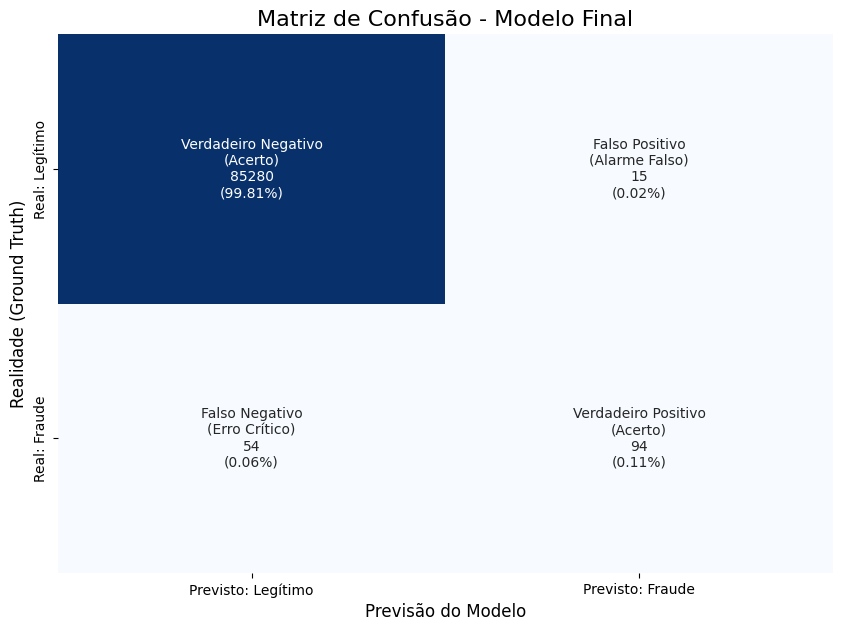

In [29]:
#executando a matriz de confusão
plot_confusion_matrix_custom(y_test, y_pred, titulo="Matriz de Confusão - Modelo Final")


<Figure size 1000x800 with 0 Axes>

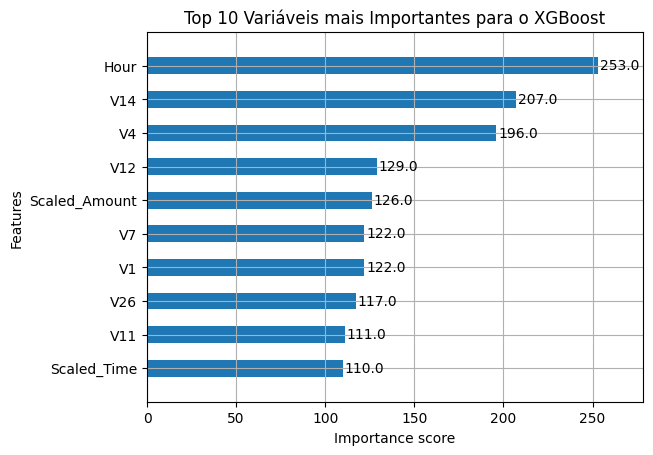

In [30]:
# 2. Feature Importance (O que o modelo considerou relevante?)
from xgboost import plot_importance

# Configura o tamanho da figura para ficar legível
plt.figure(figsize=(10, 8))

# Plota a importância
plot_importance(model_robust, max_num_features=10, importance_type='weight', height=0.5)
plt.title('Top 10 Variáveis mais Importantes para o XGBoost')
plt.show()

**Análise da Matriz de Confusão:**

- > O foco crítico neste projeto é minimizar o quadrante inferior esquerdo (**Falso Negativo**).
- > Falso Negativo (Erro Crítico): Representa fraudes reais que o modelo classificou como legítimas. Isso gera prejuízo financeiro direto.
- > Falso Positivo (Alarme Falso): Representa cartões bloqueados indevidamente. Causa atrito com o cliente, mas o custo é operacional.
- > O gráfico acima permite validar se o modelo atingiu o equilíbrio proposto entre Recall (capturar a fraude) e Precision (evitar alarmes falsos excessivos). 

## **. 🏆Conclusão**

**1. Desbalanceamento e Estratégia:** A base apresenta um desbalanceamento severo (apenas 0,17% de fraudes). Isso inviabiliza o uso da Acurácia como métrica principal. A estratégia do projeto focará na maximização do Recall (para detectar a fraude) mantendo um equilíbrio aceitável de precisão (para evitar bloqueios indevidos de clientes legítimos).

**2. Padrão Temporal (Risco na Madrugada):** Identificou-se um padrão claro de risco entre '02:00' e '04:00' da manhã. Embora o volume total de transações caia, a taxa de fraude dispara neste horário, sugerindo ataques automatizados ou oportunistas em momentos de menor vigilância humana/bancária.

**3. Comportamento Financeiro (O "Teste" do Fraudador):** A análise bivariada refutou a ideia de que fraudes são sempre valores altos. A mediana das fraudes ($9,21) é significativamente menor que a das transações legítimas ($22,00), indicando que fraudadores frequentemente testam a validade do cartão com pequenos débitos antes de realizar transações de alto valor (outliers), que elevam a média final.

**4. Recomendação de negócio:** Com base nos dados, recomenda-se a implementação imediata de uma regra de bloqueio preventivo ou exigência de autenticação forte (2FA) para transações online realizadas entre 02h e 04h da manhã, especialmente aquelas precedidas por tentativas de valor baixo (< $10), mitigando o risco de maior impacto financeiro.